In [ ]:
import time
import uproot

the file here is a part of `data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026`:
```
/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1
```

In [ ]:
! ls -lh /data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1

In [ ]:
# read out of XCache, which is faster
fname = "root://192.170.240.147//root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlaslocalgroupdisk/rucio/data18_13TeV/36/2c/DAOD_PHYSLITE.37021624._000036.pool.root.1"
t = uproot.open({fname: "CollectionTree"})

branch_metadata = {}
cur_size_in_MB = t.file.source.num_requested_bytes/1000**2  # non-zero at the start (some metadata read)

num_branches = len(t.keys())

for i, key in enumerate(t.keys()):
    # if not any([key.startswith(v) for v in ["AnalysisJetsAuxDyn", "AnalysisLargeRJetsAuxDyn", "AnalysisElectronsAuxDyn", "AnalysisMuonsAuxDyn", "AnalysisTauJetsAuxDyn", "AnalysisPhotonsAuxDyn"]]):
    #     continue

    cur_size_in_MB = t.file.source.num_requested_bytes/1000**2
    progress = f"{i} / {num_branches}"
    try:
        t0 = time.perf_counter()
        t[key].array()
        t1 = time.perf_counter()
        print(f"{progress} {key}")
    except:
        t0 = 0
        t1 = 0
        print(f"{progress} [CANNOT READ] {key}")
        
    new_size_in_MB = t.file.source.num_requested_bytes/1000**2
    branch_metadata[key] = {"size": new_size_in_MB - cur_size_in_MB, "time": t1-t0}

# branch_metadata

In [ ]:
print(f"all branches: {sum(size_per_key_in_MB.values())} MB")  # doesn't include initial metadata read

In [ ]:
import os
fname_local = "/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1"
file_size = os.path.getsize(fname_local) / 1000**2
file_size

In [ ]:
t.file.source.num_requested_bytes/1000**2

sanity check: looks like we read most of the file, seems good

In [ ]:
import json

branch_metadata["_file_size"] = file_size

with open("branch_sizes.json", "w") as f:
    f.write(json.dumps(branch_metadata, sort_keys=True, indent=4))

## sort branches, find branches to hit 15% read

In [1]:
import json
import pathlib
import copy

branch_metadata = json.loads(pathlib.Path("branch_sizes.json").read_text())
file_size = branch_metadata.pop("_file_size")

list_of_branches_to_read = []
size_of_branches = 0

# veto the metadata branch and also possibly problematic ones that could vary a lot across files
branches_to_veto = [
    "_file_size",
    "InDetTrackParticlesAuxDyn.definingParametersCovMatrixOffDiag",
    "InDetTrackParticlesAuxDyn.definingParametersCovMatrixDiag",
    "MuonSpectrometerTrackParticlesAuxDyn.definingParametersCovMatrixOffDiag",
    "AntiKt10UFOCSSKJetsAux./AntiKt10UFOCSSKJetsAux.constituentLinks",
    "ExtrapolatedMuonTrackParticlesAuxDyn.definingParametersCovMatrixOffDiag",
    "CombinedMuonTrackParticlesAuxDyn.definingParametersCovMatrixOffDiag",
    "AnalysisJetsAuxDyn.btaggingLink",
    "AnalysisJetsAuxDyn.GhostTrack",
    "PrimaryVerticesAuxDyn.trackParticleLinks",
    "PrimaryVerticesAuxDyn.neutralParticleLinks",
    "AnalysisJetsAuxDyn.EnergyPerSampling",  # unreadable in some files
    "AnalysisJetsAuxDyn.SumPtTrkPt500",  # unreadable in some files 
    "AnalysisJetsAuxDyn.TrackWidthPt1000",  # unreadable in some files 
    "AnalysisJetsAuxDyn.NumTrkPt500",  # unreadable in some files
    "AnalysisPhotonsAuxDyn.f1"  # presumably missing in p5885
]

# start with a few hardcoded branches
list_of_branches_to_read = [
    # "AnalysisJetsAuxDyn.pt",
    # "AnalysisJetsAuxDyn.eta",
    # "AnalysisJetsAuxDyn.phi",
    # "AnalysisJetsAuxDyn.m",
    # "AnalysisElectronsAuxDyn.pt",
    # "AnalysisElectronsAuxDyn.eta",
    # "AnalysisElectronsAuxDyn.phi",
    # "AnalysisElectronsAuxDyn.m",
    # "AnalysisMuonsAuxDyn.pt",
    # "AnalysisMuonsAuxDyn.eta",
    # "AnalysisMuonsAuxDyn.phi",
]
size_of_branches += sum(v["size"] for k, v in branch_metadata.items() if k in list_of_branches_to_read)


# sort by decreasing size per time
for k, v in reversed(sorted(branch_metadata.items(), key=lambda it: it[1]["size"] / (it[1]["time"] + 1e-6))):
    # only keep branches relating to specific physics objects
    if not any([vv in k for vv in [
                "AnalysisJetsAuxDyn",
                "AnalysisElectronsAuxDyn",
                "AnalysisMuonsAuxDyn",
                "AnalysisPhotonsAuxDyn",
                "AnalysisTauJetsAuxDyn",
                "PrimaryVerticesAuxDyn"
                ]
            ]):
        continue

    if k in list_of_branches_to_read:
        continue  # already listed in hardcoded branches above

    if k in branches_to_veto:
        continue

    list_of_branches_to_read.append(k)
    size_of_branches += v["size"]
    if size_of_branches / file_size > 0.15:  # target: 15%
        break

print(f"fraction of file read with all these branches: {size_of_branches / file_size:.2%}")

for b in list_of_branches_to_read:
    print(f"{b}: {branch_metadata[b]['size'] / file_size:.2%}, {branch_metadata[b]['time']:.3f} s",
          f"size per time: {branch_metadata[b]['size'] / branch_metadata[b]['time']:.1f} MB/s")

fraction of file read with all these branches: 15.04%
PrimaryVerticesAuxDyn.z: 1.17%, 0.120 s size per time: 109.0 MB/s
PrimaryVerticesAuxDyn.x: 0.96%, 0.118 s size per time: 91.4 MB/s
PrimaryVerticesAuxDyn.y: 0.94%, 0.115 s size per time: 91.2 MB/s
AnalysisJetsAuxDyn.Timing: 0.47%, 0.080 s size per time: 66.3 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi: 0.47%, 0.082 s size per time: 64.1 MB/s
AnalysisJetsAuxDyn.DetectorEta: 0.47%, 0.082 s size per time: 63.7 MB/s
AnalysisJetsAuxDyn.ActiveArea4vec_eta: 0.47%, 0.083 s size per time: 63.6 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta: 0.47%, 0.083 s size per time: 63.0 MB/s
AnalysisJetsAuxDyn.phi: 0.47%, 0.083 s size per time: 62.9 MB/s
AnalysisJetsAuxDyn.m: 0.45%, 0.082 s size per time: 61.9 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt: 0.45%, 0.082 s size per time: 61.7 MB/s
AnalysisJetsAuxDyn.ActiveArea4vec_phi: 0.47%, 0.085 s size per time: 61.6 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_m: 0.46%, 0.085 s siz

In [2]:
# list for notebook doing the reading
list_of_branches_to_read

['PrimaryVerticesAuxDyn.z',
 'PrimaryVerticesAuxDyn.x',
 'PrimaryVerticesAuxDyn.y',
 'AnalysisJetsAuxDyn.Timing',
 'AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi',
 'AnalysisJetsAuxDyn.DetectorEta',
 'AnalysisJetsAuxDyn.ActiveArea4vec_eta',
 'AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta',
 'AnalysisJetsAuxDyn.phi',
 'AnalysisJetsAuxDyn.m',
 'AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt',
 'AnalysisJetsAuxDyn.ActiveArea4vec_phi',
 'AnalysisJetsAuxDyn.JetConstitScaleMomentum_m',
 'AnalysisJetsAuxDyn.ActiveArea4vec_m',
 'AnalysisJetsAuxDyn.pt',
 'AnalysisJetsAuxDyn.Width',
 'AnalysisJetsAuxDyn.EMFrac',
 'AnalysisJetsAuxDyn.ActiveArea4vec_pt',
 'AnalysisJetsAuxDyn.PSFrac',
 'AnalysisJetsAuxDyn.JVFCorr',
 'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1',
 'AnalysisJetsAuxDyn.eta',
 'AnalysisPhotonsAuxDyn.topoetcone40_CloseByCorr',
 'AnalysisPhotonsAuxDyn.topoetcone40',
 'AnalysisPhotonsAuxDyn.eta',
 'AnalysisJetsAuxDyn.DFCommonJets_fJvt',
 'AnalysisPhotonsAuxDyn.phi',
 'AnalysisPhoto

In [3]:
# code for dask-awkard with coffea schema
for branch in list_of_branches_to_read:
    trans = {"AnalysisJetsAuxDyn": "Jets", "AnalysisMuonsAuxDyn": "Muons", "AnalysisElectronsAuxDyn": "Electrons", "PrimaryVerticesAuxDyn": "PrimaryVertices"}
    for t1, t2 in trans.items():
        branch = branch.replace(t1, t2)
    link_branch_addition = "['m_persIndex']" if "Link" in branch else ""
    print(f"_counter += ak.count_nonzero(events.{branch}{link_branch_addition})")

_counter += ak.count_nonzero(events.PrimaryVertices.z)
_counter += ak.count_nonzero(events.PrimaryVertices.x)
_counter += ak.count_nonzero(events.PrimaryVertices.y)
_counter += ak.count_nonzero(events.Jets.Timing)
_counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_phi)
_counter += ak.count_nonzero(events.Jets.DetectorEta)
_counter += ak.count_nonzero(events.Jets.ActiveArea4vec_eta)
_counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_eta)
_counter += ak.count_nonzero(events.Jets.phi)
_counter += ak.count_nonzero(events.Jets.m)
_counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_pt)
_counter += ak.count_nonzero(events.Jets.ActiveArea4vec_phi)
_counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_m)
_counter += ak.count_nonzero(events.Jets.ActiveArea4vec_m)
_counter += ak.count_nonzero(events.Jets.pt)
_counter += ak.count_nonzero(events.Jets.Width)
_counter += ak.count_nonzero(events.Jets.EMFrac)
_counter += ak.count_nonzero(events.Jets.A

## sanity check: load file again, read these branches, ensure we hit the right fraction of the file

In [4]:
import uproot

fname_local = "/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1"
fname = "root://192.170.240.147//root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlaslocalgroupdisk/rucio/data18_13TeV/36/2c/DAOD_PHYSLITE.37021624._000036.pool.root.1"
treename = "CollectionTree"
t = uproot.open({fname: treename})

cur_size_in_MB = t.file.source.num_requested_bytes/1000**2  # non-zero at the start (some metadata read)

t.arrays(list_of_branches_to_read)

new_size_in_MB = t.file.source.num_requested_bytes/1000**2
print(cur_size_in_MB, new_size_in_MB)

2.260006 171.272839


In [5]:
(new_size_in_MB - cur_size_in_MB) / file_size

0.15044348448771197

## time to read individual branches

In [6]:
import os
import uproot
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

filter_name = lambda name: name in list_of_branches_to_read

In [7]:
# time each branch individually, compare to size of the branch, ensure no extreme outliers are present
for i in range(len(list_of_branches_to_read)):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f[list_of_branches_to_read[i]].array()
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        time_ms = (t1-t0)*1000
        size_MB = (new_size_in_MB-initial_metadata_in_MB)
        print(f"{list_of_branches_to_read[i]:<80}: {time_ms:4.0f} ms\t\t{size_MB:>5.2f} MB\t\t{size_MB / time_ms * 1000:>5.1f} MB/s")

PrimaryVerticesAuxDyn.z                                                         :  137 ms		13.11 MB		 95.9 MB/s
PrimaryVerticesAuxDyn.x                                                         :  126 ms		10.82 MB		 85.6 MB/s
PrimaryVerticesAuxDyn.y                                                         :  126 ms		10.53 MB		 83.5 MB/s
AnalysisJetsAuxDyn.Timing                                                       :   93 ms		 5.31 MB		 57.0 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi                                  :   90 ms		 5.25 MB		 58.6 MB/s
AnalysisJetsAuxDyn.DetectorEta                                                  :   91 ms		 5.25 MB		 57.9 MB/s
AnalysisJetsAuxDyn.ActiveArea4vec_eta                                           :   91 ms		 5.25 MB		 57.6 MB/s
AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta                                  :   89 ms		 5.26 MB		 59.3 MB/s
AnalysisJetsAuxDyn.phi                                                          :   89 ms		 5.24 MB		 58

## iteratively reading more branches

In [7]:
file_size = os.path.getsize(fname_local) / 1000**2  # all sizes in MB

stepsize = 4
time_per_fraction_read = {}
for i in range(len(list_of_branches_to_read)//stepsize+1):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:  # re-open every time for accurate tracking of data read
        branches = list_of_branches_to_read[0:(i+1)*stepsize]
        print(f"reading {len(branches)} branch(es)")
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f.arrays(branches)
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        fraction_read = (new_size_in_MB - initial_metadata_in_MB) / file_size
        time_per_fraction_read[fraction_read] = t1 - t0
        print(f"  - read {new_size_in_MB - initial_metadata_in_MB:.2f} MB in {t1 - t0:.2f} s")

with uproot.open({fname: treename}) as f:
    nevts = f.num_entries

reading 4 branch(es)
  - read 39.77 MB in 0.62 s
reading 8 branch(es)
  - read 60.78 MB in 0.85 s
reading 12 branch(es)
  - read 81.39 MB in 1.34 s
reading 16 branch(es)
  - read 101.45 MB in 1.66 s
reading 20 branch(es)
  - read 118.50 MB in 2.13 s
reading 24 branch(es)
  - read 132.12 MB in 2.41 s
reading 28 branch(es)
  - read 141.23 MB in 2.74 s
reading 32 branch(es)
  - read 149.77 MB in 3.33 s
reading 36 branch(es)
  - read 158.43 MB in 3.67 s
reading 40 branch(es)
  - read 162.65 MB in 4.06 s
reading 44 branch(es)
  - read 166.31 MB in 4.50 s
reading 47 branch(es)
  - read 169.01 MB in 4.84 s


In [8]:
for k, v in time_per_fraction_read.items():
    print(f"fraction read: {k:.2%} in {v:.2f} s")

fraction read: 3.54% in 0.62 s
fraction read: 5.41% in 0.85 s
fraction read: 7.24% in 1.34 s
fraction read: 9.03% in 1.66 s
fraction read: 10.55% in 2.13 s
fraction read: 11.76% in 2.41 s
fraction read: 12.57% in 2.74 s
fraction read: 13.33% in 3.33 s
fraction read: 14.10% in 3.67 s
fraction read: 14.48% in 4.06 s
fraction read: 14.80% in 4.50 s
fraction read: 15.04% in 4.84 s


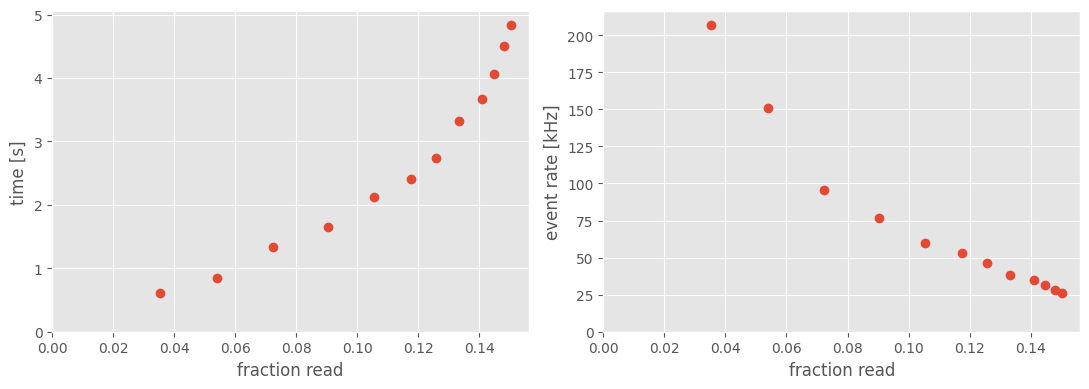

In [9]:
event_rate_in_kHz = nevts / np.fromiter(time_per_fraction_read.values(), np.float32) / 1_000

fig, (ax0, ax1) = plt.subplots(figsize=(11,4), ncols=2)

ax0.plot(time_per_fraction_read.keys(), time_per_fraction_read.values(), "o")
ax0.set_xlabel("fraction read")
ax0.set_ylabel("time [s]")
ax0.set_xlim([0, ax0.get_xlim()[1]])
ax0.set_ylim([0, ax0.get_ylim()[1]])

ax1.plot(time_per_fraction_read.keys(), event_rate_in_kHz, "o")
ax1.set_xlabel("fraction read")
ax1.set_ylabel("event rate [kHz]")
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])

figures_dir = Path.cwd() / "figures"
figures_dir.mkdir(exist_ok=True)

fig.tight_layout()
fig.savefig(figures_dir / "file_read_time.png", dpi=300)

In [10]:
# pure "metadata" (?) part, would be read on every open call
with uproot.open({fname: treename}) as f:
    print(f"{f.file.source.num_requested_bytes/1000**2:.2f} MB")

2.26 MB


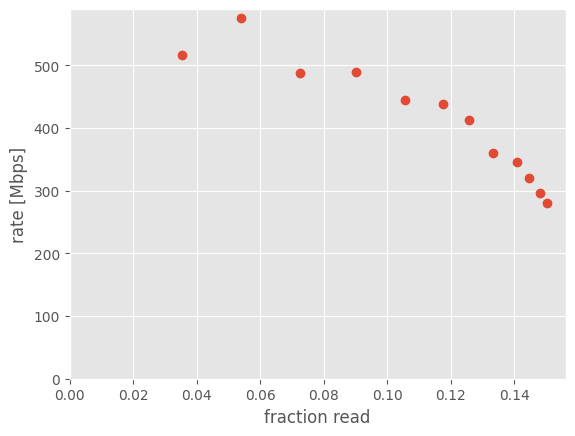

In [11]:
# fraction read * file size (in MB) * 8 (to Mb) / time (in s)
io_in_Mbps = np.fromiter(time_per_fraction_read.keys(), np.float32) * file_size * 8 / np.fromiter(time_per_fraction_read.values(), np.float32)

fig, ax = plt.subplots()

ax.plot(time_per_fraction_read.keys(), io_in_Mbps, "o")
ax.set_xlabel("fraction read")
ax.set_ylabel("rate [Mbps]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])

fig.savefig(figures_dir / "file_read_rate.png", dpi=300)

### how to read efficiently

In [12]:
import uproot

fname = "root://192.170.240.147//root://fax.mwt2.org:1094//pnfs/uchicago.edu/atlaslocalgroupdisk/rucio/data18_13TeV/36/2c/DAOD_PHYSLITE.37021624._000036.pool.root.1"
treename = "CollectionTree"

In [13]:
%%time
t = uproot.open({fname: treename})
_ = t.arrays(list_of_branches_to_read)

CPU times: user 5.81 s, sys: 354 ms, total: 6.16 s
Wall time: 6.19 s


In [14]:
%%time

# filter_name = lambda x: x in BRANCH_LIST
with uproot.open(fname) as f: #, filter_name=filter_name) as f:
    for b in list_of_branches_to_read:
        f["CollectionTree"][b].array()

CPU times: user 5.71 s, sys: 242 ms, total: 5.95 s
Wall time: 6.19 s


In [15]:
%%time
for _ in uproot.iterate({fname: treename}, expressions=list_of_branches_to_read):
    pass

CPU times: user 6.13 s, sys: 326 ms, total: 6.45 s
Wall time: 6.5 s


In [16]:
%%time
with uproot.open(fname) as f:
    for _ in f[treename].iterate(expressions=list_of_branches_to_read):
        pass

CPU times: user 6.12 s, sys: 237 ms, total: 6.36 s
Wall time: 6.39 s
